**Data Collection**

In [ ]:
import numpy as np
import os
import pandas as pd

transactions = pd.read_csv('Fraud.csv')

**Data Preprocessing**

In [ ]:
# Display the first few rows
print(transactions.head())

# Display summary statistics
print(transactions.describe())

# Display info about data types and missing values
print(transactions.info())


   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6

In [ ]:
print(transactions.isnull().sum())


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [ ]:
# Distribution of transaction types
print(transactions['type'].value_counts())

# Distribution of isFraud
print(transactions['isFraud'].value_counts())


type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64
isFraud
0    6354407
1       8213
Name: count, dtype: int64


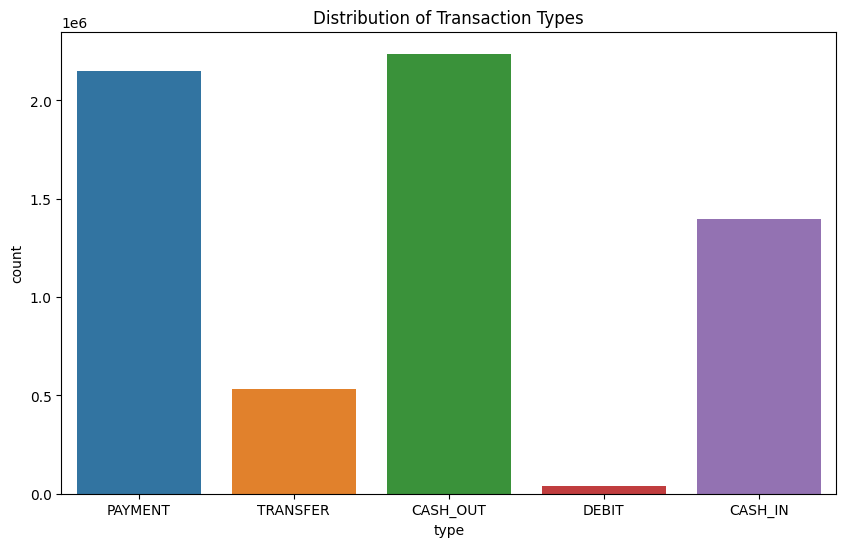

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


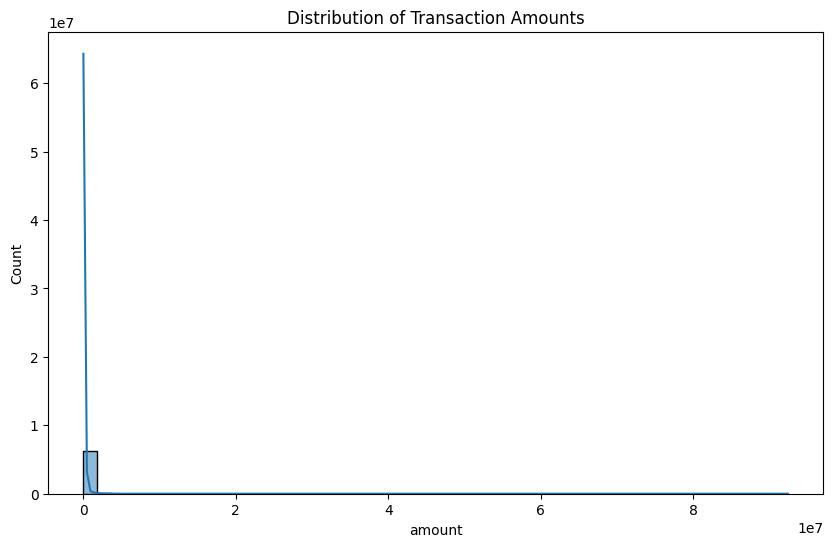

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of transaction types
plt.figure(figsize=(10, 6))
sns.countplot(data=transactions, x='type')
plt.title('Distribution of Transaction Types')
plt.show()

# Plot distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(transactions['amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.show()




In [ ]:
sample_size = 100000  # Adjust the sample size as needed
df_sampled = transactions.sample(n=sample_size, random_state=42)

In [ ]:
print(df_sampled.dtypes)

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


**Feature Encoding**

In [ ]:
df_sampled = pd.get_dummies(df_sampled, columns=['type'])

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoders
le_nameOrig = LabelEncoder()
le_nameDest = LabelEncoder()

# Fit and transform the 'nameOrig' and 'nameDest' fields
df_sampled['nameOrig'] = le_nameOrig.fit_transform(df_sampled['nameOrig'])
df_sampled['nameDest'] = le_nameDest.fit_transform(df_sampled['nameDest'])

# Display the data types after encoding
print("Data types after encoding:")
print(df_sampled.dtypes)

Data types after encoding:
step                int64
amount            float64
nameOrig            int64
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest            int64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
type_CASH_IN         bool
type_CASH_OUT        bool
type_DEBIT           bool
type_PAYMENT         bool
type_TRANSFER        bool
dtype: object


**Feature Extraction**

In [ ]:
df_sampled['amount_to_oldbalanceOrg_ratio'] = df_sampled['amount'] / (df_sampled['oldbalanceOrg'] + 1)  # +1 to avoid division by zero
df_sampled['amount_to_oldbalanceDest_ratio'] = df_sampled['amount'] / (df_sampled['oldbalanceDest'] + 1)  # +1 to avoid division by zero

# Change in balance after the transaction
df_sampled['balanceOrg_delta'] = df_sampled['newbalanceOrig'] - df_sampled['oldbalanceOrg']
df_sampled['balanceDest_delta'] = df_sampled['newbalanceDest'] - df_sampled['oldbalanceDest']

# Historical fraud count for each customer (assuming historical data is available)
df_sampled['orig_fraud_count'] = df_sampled.groupby('nameOrig')['isFraud'].transform('sum')
df_sampled['dest_fraud_count'] = df_sampled.groupby('nameDest')['isFraud'].transform('sum')

# Count of each transaction type per customer
df_sampled['orig_transaction_count'] = df_sampled.groupby('nameOrig')['step'].transform('count')
df_sampled['dest_transaction_count'] = df_sampled.groupby('nameDest')['step'].transform('count')


In [ ]:
df_sampled['hour_of_day'] = df_sampled['step'] % 24
df_sampled['day_of_week'] = (df_sampled['step'] // 24) % 7
df_sampled['is_business_hours'] = df_sampled['hour_of_day'].apply(lambda x: 1 if 9 <= x <= 17 else 0)


**Exploratory Data Analysis**

                step        amount       nameOrig  oldbalanceOrg  \
count  100000.000000  1.000000e+05  100000.000000   1.000000e+05   
mean      243.709070  1.805811e+05   49999.416130   8.366804e+05   
std       142.518613  5.586699e+05   28867.524713   2.901104e+06   
min         1.000000  9.200000e-01       0.000000   0.000000e+00   
25%       156.000000  1.350821e+04   24999.750000   0.000000e+00   
50%       240.000000  7.603086e+04   49999.500000   1.393850e+04   
75%       335.000000  2.091130e+05   74999.250000   1.070771e+05   
max       736.000000  3.697390e+07   99998.000000   3.359321e+07   

       newbalanceOrig       nameDest  oldbalanceDest  newbalanceDest  \
count    1.000000e+05  100000.000000    1.000000e+05    1.000000e+05   
mean     8.582234e+05   45276.808060    1.104193e+06    1.230055e+06   
std      2.936799e+06   26602.013004    3.223011e+06    3.475326e+06   
min      0.000000e+00       0.000000    0.000000e+00    0.000000e+00   
25%      0.000000e+00   223

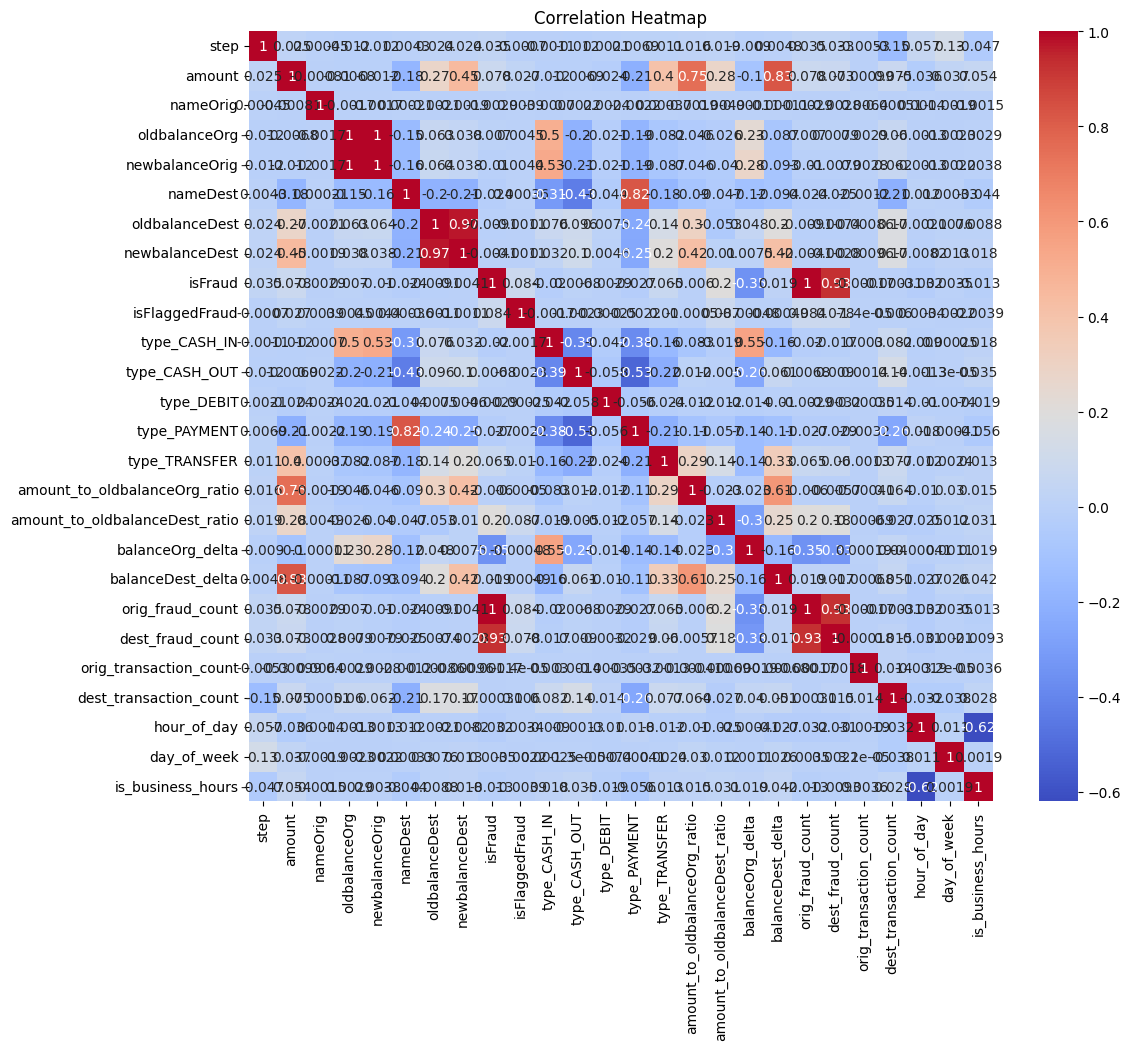

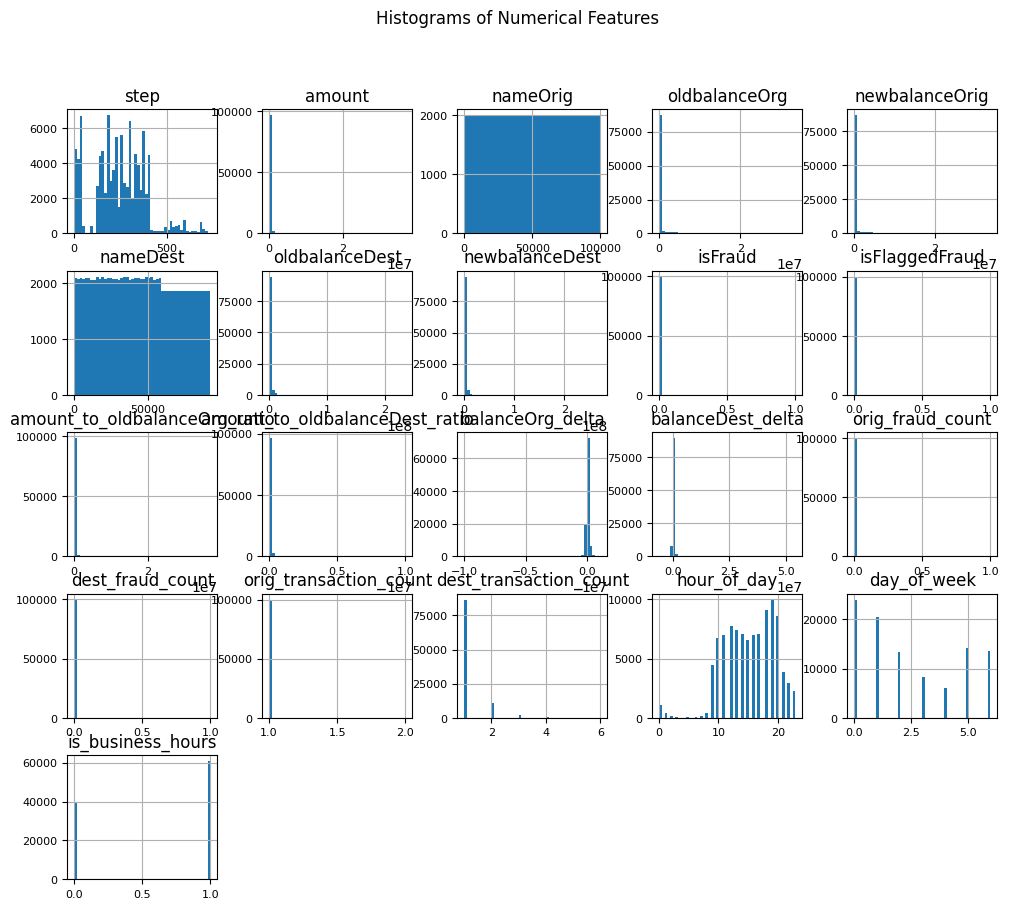

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

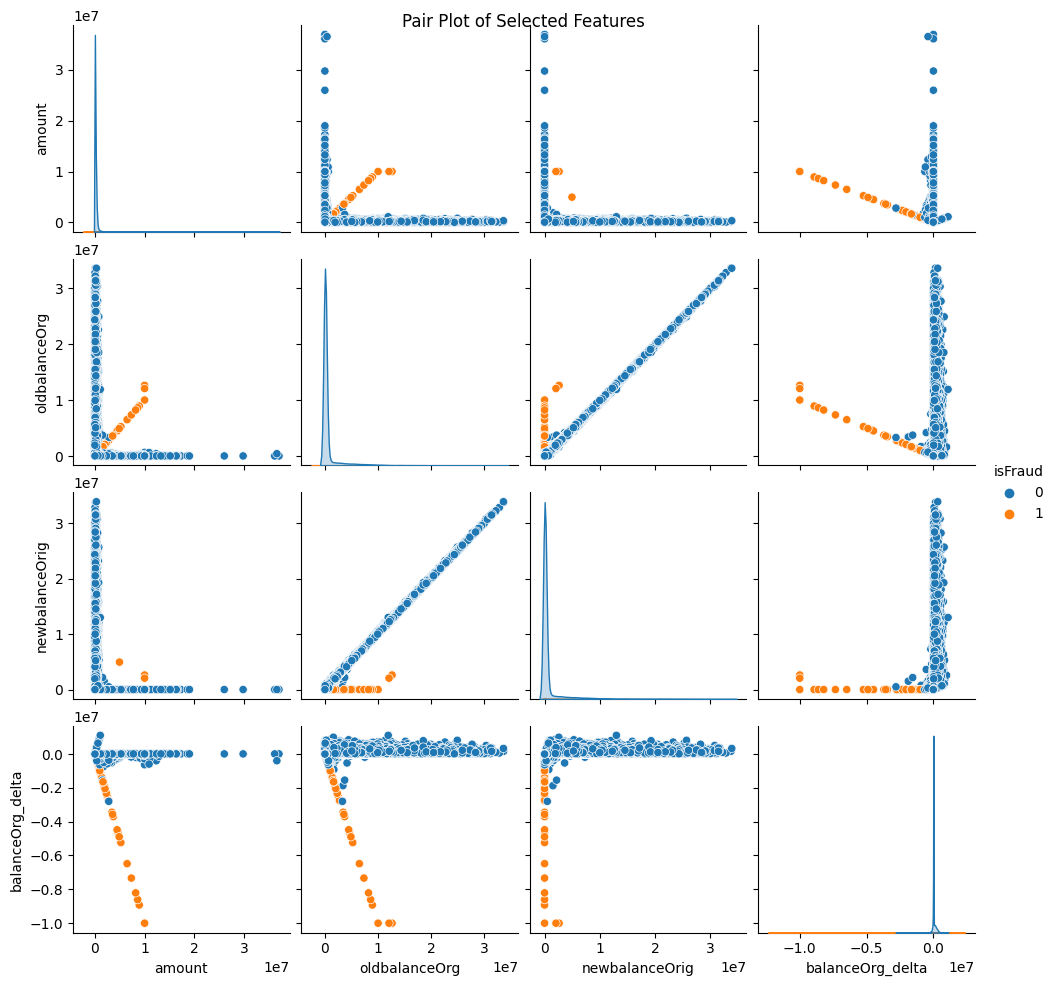

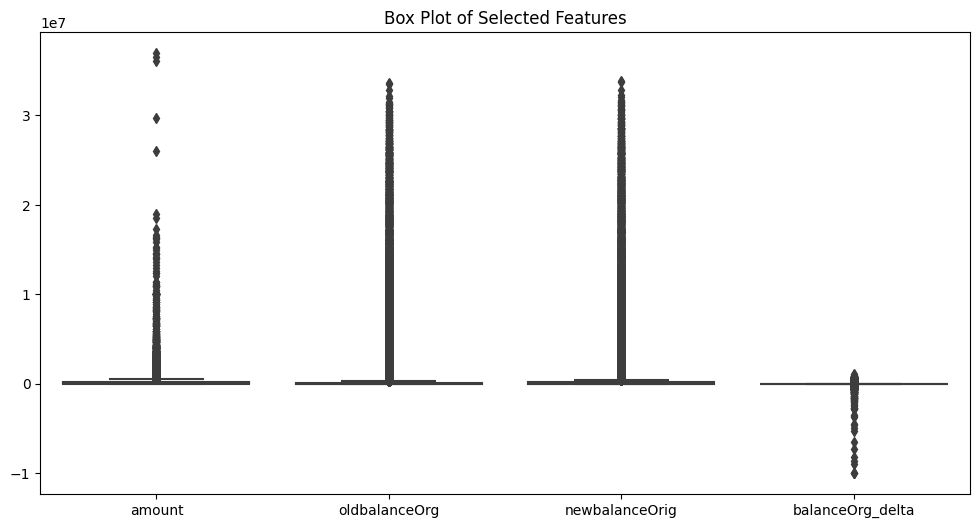

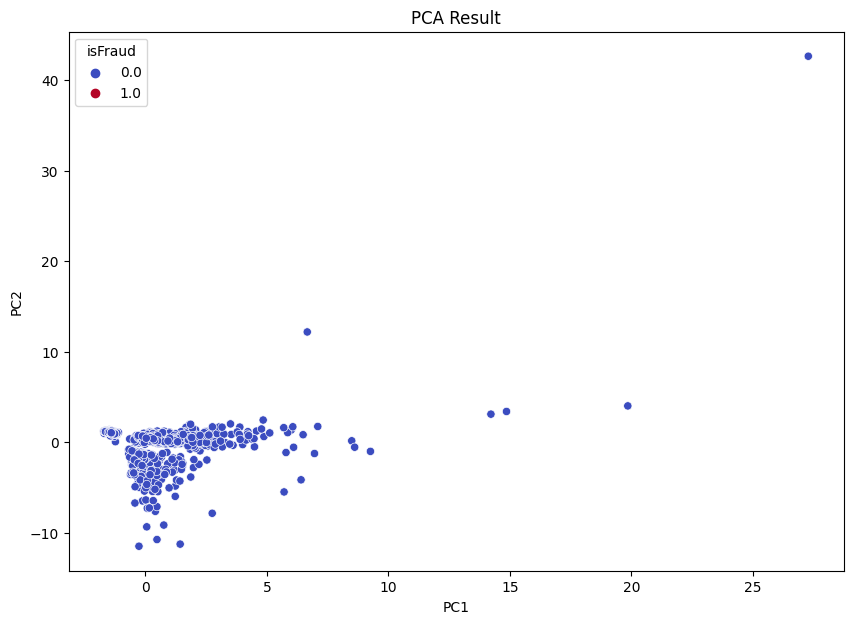

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Descriptive Statistics
print(df_sampled.describe())

# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df_sampled.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Histograms for Numerical Features
df_sampled.hist(figsize=(12, 10), bins=50, xlabelsize=8, ylabelsize=8)
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Pair Plot
sns.pairplot(df_sampled[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'balanceOrg_delta', 'isFraud']], hue='isFraud')
plt.suptitle('Pair Plot of Selected Features')
plt.show()

# Box Plot for Outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_sampled[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'balanceOrg_delta']])
plt.title('Box Plot of Selected Features')
plt.show()

# PCA for Dimensionality Reduction
features = df_sampled.drop(columns=['isFraud'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca['isFraud'] = df_sampled['isFraud']

plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='isFraud', data=df_pca, palette='coolwarm')
plt.title('PCA Result')
plt.show()


**Training and Test Set Split**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define features and target variable
X = df_sampled.drop(columns=['isFraud'])
y = df_sampled['isFraud']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Model Selection and Training**

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report


# Train and evaluate Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)


# Train and evaluate SVM model
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)


# Train and evaluate Neural Network model
nn_model = MLPClassifier(random_state=42, max_iter=300)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict(X_test)
accuracy_nn = accuracy_score(y_test, y_pred_nn)



**Model Evaluation**

In [ ]:
print(f'Random Forest Accuracy: {accuracy_rf:.4f}')
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print(f'SVM Accuracy: {accuracy_svm:.4f}')
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

print(f'Neural Network Accuracy: {accuracy_nn:.4f}')
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))

Random Forest Accuracy: 1.0000
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19972
           1       1.00      1.00      1.00        28

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

SVM Accuracy: 0.9990
SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19972
           1       1.00      0.25      0.40        28

    accuracy                           1.00     20000
   macro avg       1.00      0.62      0.70     20000
weighted avg       1.00      1.00      1.00     20000

Neural Network Accuracy: 0.9988
Neural Network Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19972
           1       0.54      0.68      0.60        